In [1]:
#Creamos las carpetas deseadas.
!mkdir Dianas
!mkdir no_Dianas
!mkdir TEST

In [2]:
#mostramos el contenido de las carpetas.
!ls /content/Dianas | wc -l
!ls /content/no_Dianas | wc -l
!ls /content/TEST | wc -l

100
100
8


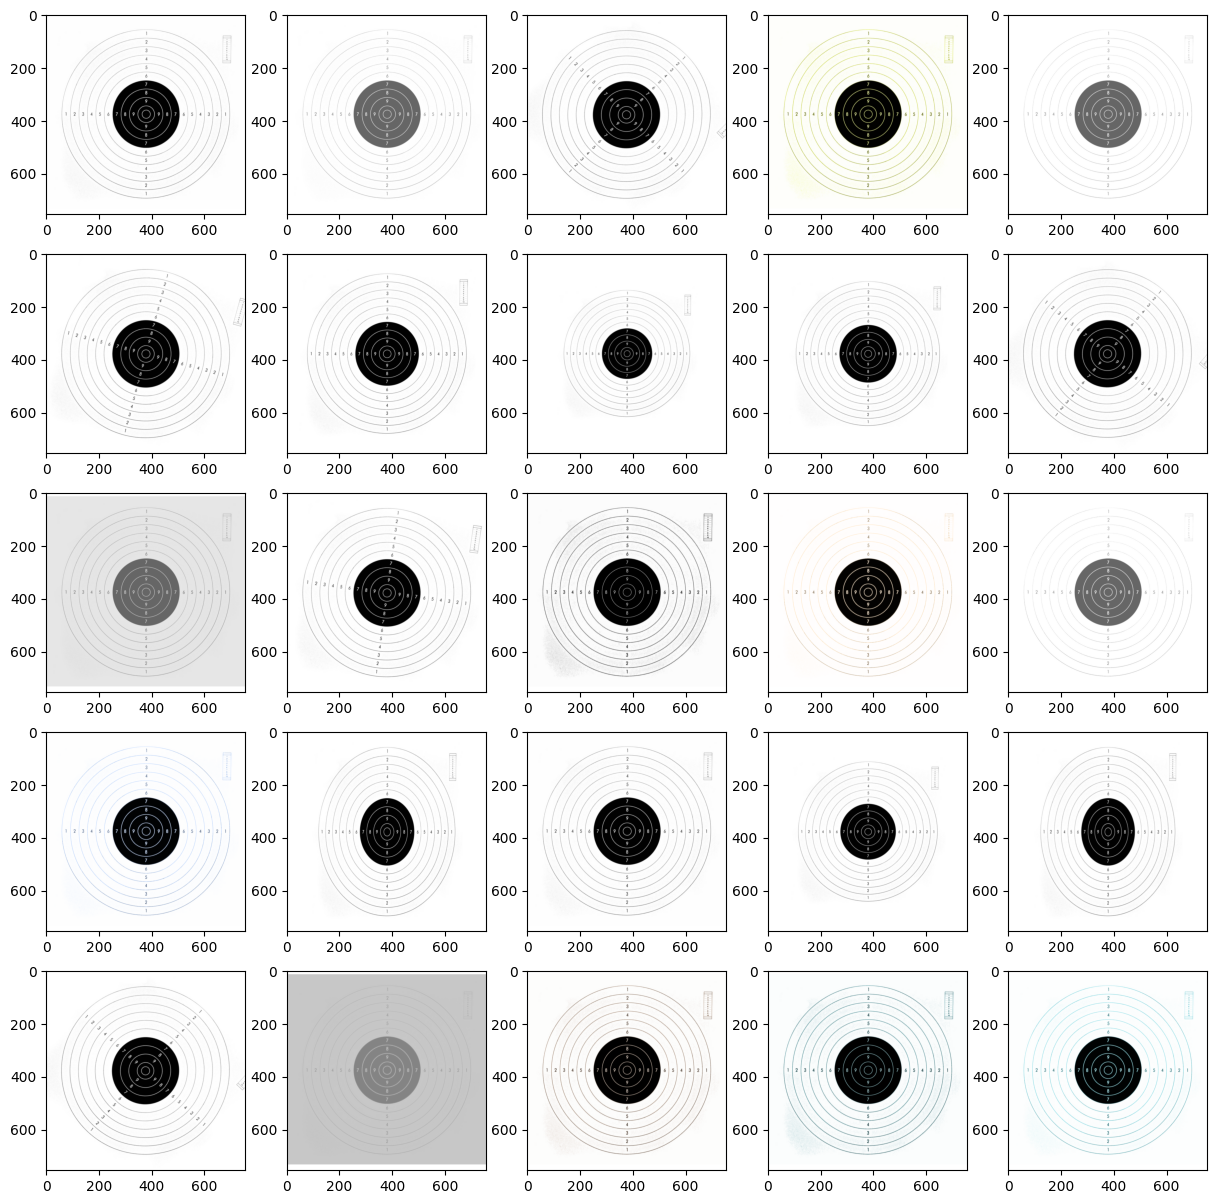

In [3]:
#mostramos mas imagenes
import os
import matplotlib.pyplot as plt
import matplotlib.image as mping

plt.figure(figsize=(15,15))

carpeta = '/content/Dianas'
imagenes = os.listdir(carpeta)

for i, nombreimg in enumerate(imagenes[:25]):
    plt.subplot(5,5,i+1)
    imagen = mping.imread(carpeta + '/' + nombreimg)
    plt.imshow(imagen)

In [4]:
#crear carpetas para hacer el set de datos.
!mkdir dataset
!mkdir dataset/Diana
!mkdir dataset/no_Dianas

In [5]:
import shutil
import os

# Especifica las rutas de las carpetas de origen y destino
ruta_origen = '/content/Dianas'
ruta_destino = '/content/dataset/Diana'

# Obtener una lista de todos los archivos en la carpeta de origen
archivos = os.listdir(ruta_origen)

# Copiar cada archivo a la carpeta de destino sin eliminarlos de la carpeta de origen
for archivo in archivos:
    shutil.copy(os.path.join(ruta_origen, archivo), ruta_destino)

In [6]:
import shutil
import os

# Especifica las rutas de las carpetas de origen y destino
ruta_origen = '/content/no_Dianas'
ruta_destino = '/content/dataset/no_Dianas'

# Obtener una lista de todos los archivos en la carpeta de origen
archivos = os.listdir(ruta_origen)

# Copiar cada archivo a la carpeta de destino sin eliminarlos de la carpeta de origen
for archivo in archivos:
    shutil.copy(os.path.join(ruta_origen, archivo), ruta_destino)

In [7]:
#mostramos el contenido de las carpetas.
!ls /content/dataset/Diana| wc -l
!ls /content/dataset/no_Dianas| wc -l

100
100


Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


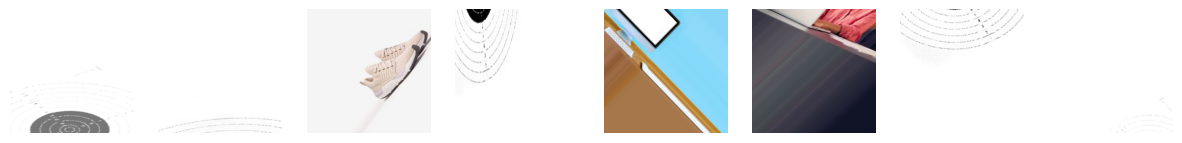

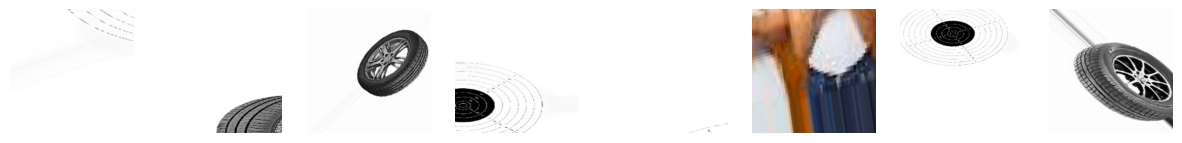

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Crear el generador de imágenes con transformaciones
datagen = ImageDataGenerator(rescale=1./255, 
                             validation_split=0.2,
                             rotation_range=60,
                             width_shift_range=0.8,
                             height_shift_range=0.5,
                             zoom_range=0.7,
                             horizontal_flip=True)

# Crear el generador de entrenamiento
data_gen_entrenamiento = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset='training'
)

# Crear el generador de validación
data_gen_validacion = datagen.flow_from_directory(
    '/content/dataset',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True,
    subset='validation'
)

def mostrar_ejemplos(data_gen, num_ejemplos=8):
    imagenes, _ = next(data_gen)
    fig, axs = plt.subplots(1, num_ejemplos, figsize=(15, 15))
    for i in range(num_ejemplos):
        axs[i].imshow(imagenes[i])
        axs[i].axis('off')
    plt.show()

# Mostrar ejemplos del conjunto de entrenamiento
mostrar_ejemplos(data_gen_entrenamiento)

# Mostrar ejemplos del conjunto de validación
mostrar_ejemplos(data_gen_validacion)

In [9]:
print(data_gen_validacion.class_indices)

{'Diana': 0, 'no_Dianas': 1}


In [10]:
indices_de_clase = data_gen_validacion.class_indices

In [11]:
#modelo preentrenado.
import tensorflow as tf
import tensorflow_hub as hub

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
mobilenetv2 = hub.KerasLayer(url, input_shape=(224,224,3))

In [12]:
modelo = tf.keras.Sequential([
   mobilenetv2,
   tf.keras.layers.Dense(2, activation = 'softmax') 
])

In [13]:
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [14]:
modelo.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
#entrenar el modelo.
EPOCAS=50

historial = modelo.fit(
    data_gen_entrenamiento, epochs=50, batch_size=32,
    validation_data=data_gen_validacion
)

Epoch 1/50
5/5 [==============================] - 16s 892ms/step - loss: 0.7280 - accuracy: 0.6000 - val_loss: 0.3133 - val_accuracy: 0.8750
Epoch 2/50
5/5 [==============================] - 3s 589ms/step - loss: 0.3603 - accuracy: 0.8438 - val_loss: 0.3792 - val_accuracy: 0.8000
Epoch 3/50
5/5 [==============================] - 4s 791ms/step - loss: 0.2291 - accuracy: 0.9062 - val_loss: 0.2158 - val_accuracy: 0.8750
Epoch 4/50
5/5 [==============================] - 3s 573ms/step - loss: 0.1567 - accuracy: 0.9375 - val_loss: 0.2656 - val_accuracy: 0.8250
Epoch 5/50
5/5 [==============================] - 3s 577ms/step - loss: 0.0992 - accuracy: 0.9563 - val_loss: 0.2348 - val_accuracy: 0.8750
Epoch 6/50
5/5 [==============================] - 3s 594ms/step - loss: 0.1355 - accuracy: 0.9375 - val_loss: 0.0966 - val_accuracy: 1.0000
Epoch 7/50
5/5 [==============================] - 3s 620ms/step - loss: 0.1288 - accuracy: 0.9187 - val_loss: 0.1795 - val_accuracy: 0.9250
Epoch 8/50
5/5 [===

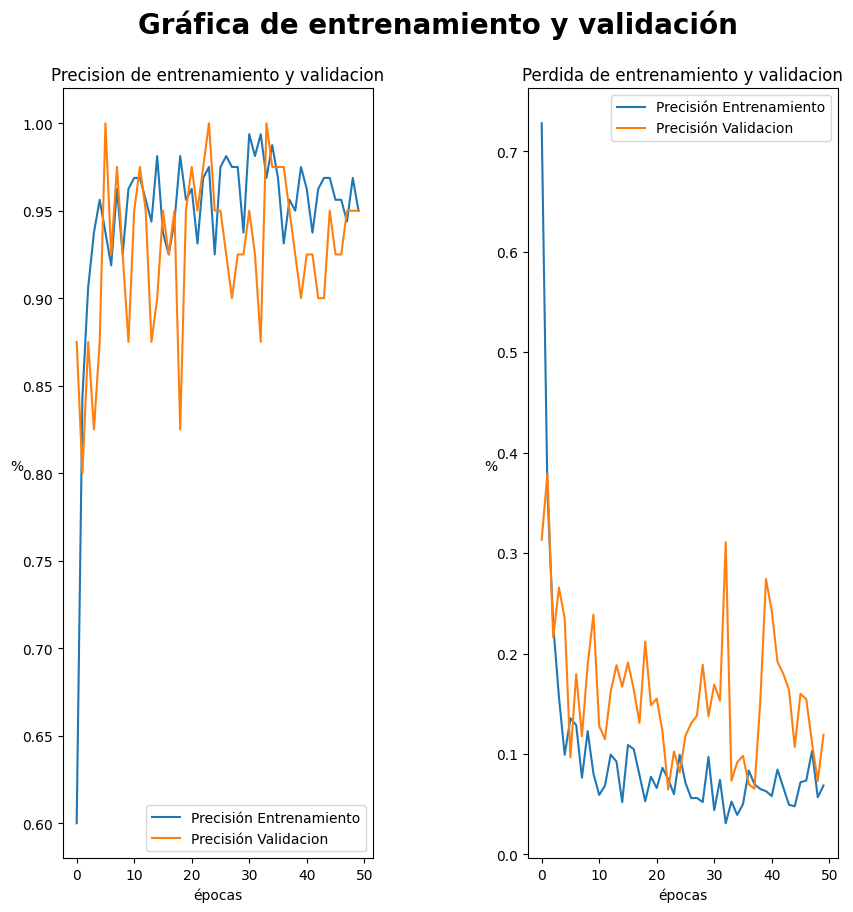

In [16]:
#grafica de acc.
acc = historial.history['accuracy']
val_acc = historial.history['val_accuracy']

loss = historial.history['loss']
val_loss = historial.history['val_loss']

rango_epocas = range(50)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(rango_epocas, acc, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_acc, label='Precisión Validacion')
plt.legend(loc='lower right')
plt.title('Precision de entrenamiento y validacion')
plt.xlabel('épocas')
plt.ylabel('%', rotation=0)

plt.subplot(1,2,2)
plt.plot(rango_epocas, loss, label='Precisión Entrenamiento')
plt.plot(rango_epocas, val_loss, label='Precisión Validacion')
plt.legend(loc='upper right')
plt.title('Perdida de entrenamiento y validacion')
plt.xlabel('épocas')
plt.ylabel('%', rotation=0)

plt.suptitle('Gráfica de entrenamiento y validación', fontsize=20, fontweight='bold', y=0.959)
plt.subplots_adjust(wspace=0.5)

plt.show()

# **1. Test**

Test 1
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 0


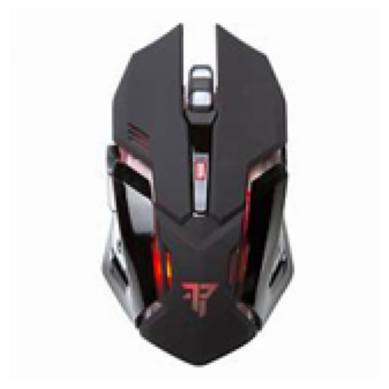

1/1 [==============================] - 1s 842ms/step
Clase 0: 0.001
Clase 1: 0.999
1/1 [==============================] - 0s 21ms/step
La clase predicha es no_Dianas (número 1) con una precisión de 0.999.


In [17]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 1')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")

# **2. Test**

Test 2
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 1


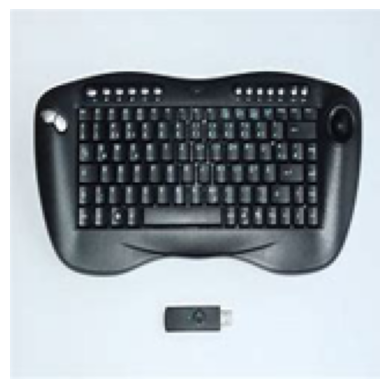

1/1 [==============================] - 0s 21ms/step
Clase 0: 0.006
Clase 1: 0.994
1/1 [==============================] - 0s 21ms/step
La clase predicha es no_Dianas (número 1) con una precisión de 0.982.


In [18]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 2')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")

# **3. Test**

Test 3
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 2


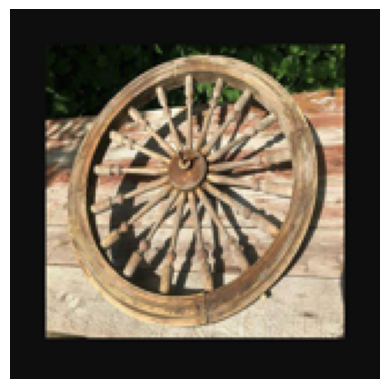

1/1 [==============================] - 0s 31ms/step
Clase 0: 0.063
Clase 1: 0.937
1/1 [==============================] - 0s 21ms/step
La clase predicha es no_Dianas (número 1) con una precisión de 0.823.


In [19]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 3')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")

# **4. Test**

Test 4
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 3


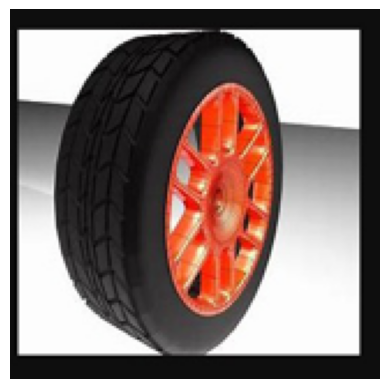

1/1 [==============================] - 0s 21ms/step
Clase 0: 0.008
Clase 1: 0.992
1/1 [==============================] - 0s 20ms/step
La clase predicha es no_Dianas (número 1) con una precisión de 0.991.


In [20]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 4')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")

# **5. Test**

Test 5
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 4


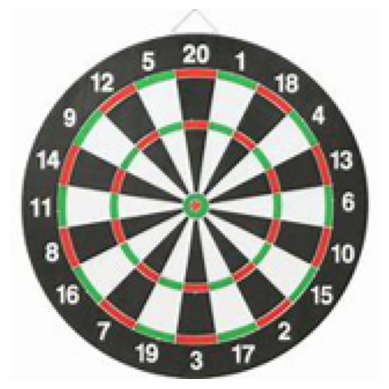

1/1 [==============================] - 0s 57ms/step
Clase 0: 0.195
Clase 1: 0.805
1/1 [==============================] - 0s 30ms/step
La clase predicha es no_Dianas (número 1) con una precisión de 0.720.


In [21]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 5')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")

# **6. Test**

Test 6
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 5


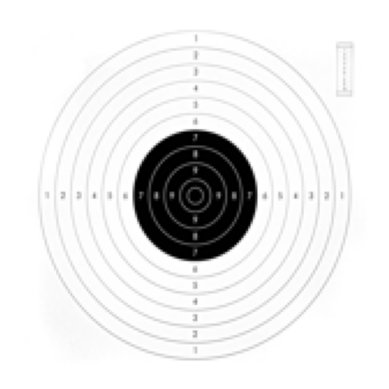

1/1 [==============================] - 0s 26ms/step
Clase 0: 1.000
Clase 1: 0.000
1/1 [==============================] - 0s 22ms/step
La clase predicha es Diana (número 0) con una precisión de 1.000.


In [22]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 6')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")

# **7. Test**

Test 7
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 6


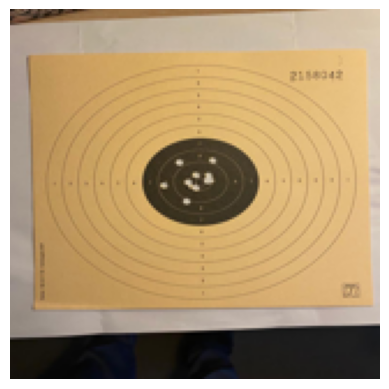

1/1 [==============================] - 0s 23ms/step
Clase 0: 0.997
Clase 1: 0.003
1/1 [==============================] - 0s 22ms/step
La clase predicha es Diana (número 0) con una precisión de 0.996.


In [23]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 7')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")

# **8. Test**

Test 8
Las imágenes disponibles son:
0: 0.Mouse.jpg
1: 1.Teclado.jpg
2: 2.Rueda de carro.jpg
3: 3.Rueda de coche.jpg
4: 4.Diana de dardo.jpg
5: 5.DIANA (train).jpeg
6: 6.Diana aire comprimido.jpg
7: 7.Diana colores.jpg
Por favor, seleccione un número de imagen: 7


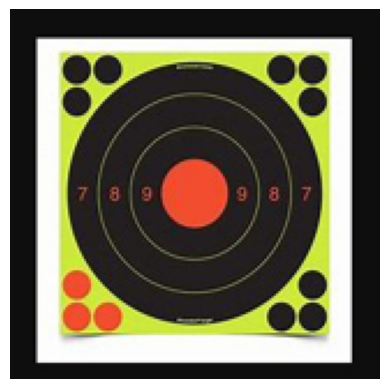

1/1 [==============================] - 0s 21ms/step
Clase 0: 0.966
Clase 1: 0.034
1/1 [==============================] - 0s 26ms/step
La clase predicha es Diana (número 0) con una precisión de 0.980.


In [24]:
import os
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import numpy as np

def categorizar(ruta_local, class_indices):
    # Cargar la imagen desde el conjunto de datos local
    img = Image.open(ruta_local)
    img = np.array(img).astype(float)/255

    img = cv2.resize(img, (224,224))
    prediccion = modelo.predict(img.reshape(-1,224,224,3))

    # Obtener la etiqueta de clase predicha y su precisión
    etiqueta_de_clase_predicha = np.argmax(prediccion[0], axis=-1)
    precision = round(prediccion[0][etiqueta_de_clase_predicha], 3)

    # Asignar la etiqueta de clase predicha a su nombre de clase correspondiente
    nombre_de_clase_predicho = list(class_indices.keys())[list(class_indices.values()).index(etiqueta_de_clase_predicha)]

    # Devolver el resultado
    return nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision

# Solicitar al usuario que ingrese la ruta de la carpeta que contiene las imágenes
ruta_carpeta = '/content/TEST'

# Comprobar si la ruta es válida
if not os.path.isdir(ruta_carpeta):
    print('La ruta especificada no es válida. Saliendo...')
else:
    # Obtener la lista de imágenes en la carpeta y ordenarla en orden ascendente
    lista_imagenes = sorted(os.listdir(ruta_carpeta))

    # Mostrar la lista de imágenes disponibles
    print('Test 8')
    print('Las imágenes disponibles son:')
    for i, imagen in enumerate(lista_imagenes):
        print(f'{i}: {imagen}')

    # Solicitar al usuario que seleccione un número de imagen
    num_imagen = int(input('Por favor, seleccione un número de imagen: '))

    # Comprobar si el número de imagen es válido
    if num_imagen < 0 or num_imagen >= len(lista_imagenes):
        print('Número de imagen inválido. Saliendo...')
    else:
        # Seleccionar la imagen correspondiente al número seleccionado
        imagen_seleccionada = lista_imagenes[num_imagen]
        ruta_imagen_seleccionada = os.path.join(ruta_carpeta, imagen_seleccionada)

        # Cargar la imagen seleccionada y mostrarla
        img = Image.open(ruta_imagen_seleccionada)
        img = img.rotate(0, expand=True)
        img = img.resize((160, 160))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Preprocesar la imagen seleccionada
        img_copy = img.copy()
        img_copy = img_copy.resize((224, 224))
        x = np.array(img_copy).astype(float)/255
        x = np.expand_dims(x, axis=0)

        # Realizar la predicción y mostrar los resultados
        prediccion = modelo.predict(x)
        for i in range(len(prediccion[0])):
            print(f"Clase {i}: {prediccion[0][i]:.3f}")
        nombre_de_clase_predicho, etiqueta_de_clase_predicha, precision = categorizar(ruta_imagen_seleccionada, indices_de_clase)
        print(f"La clase predicha es {nombre_de_clase_predicho} (número {etiqueta_de_clase_predicha}) con una precisión de {precision:.3f}.")